**Models**:
- Logistic Regression (LR)
- Random Forest (RF)
- Neural Network (NN)

# Table of Contents

>[Table of Contents](#scrollTo=1vIrrlI5qYYy)

>[Load Packages](#scrollTo=7kYT-Av0M30Y)

>[Load Datasets and Basic Data Cleaning](#scrollTo=W8j2Yk93M30a)

>>[BC & RF: features dataset](#scrollTo=ogBM3dkMM30a)

>>[NN: sites_data.csv](#scrollTo=XsGpGZJoM30b)

>>[All: Pollution Data](#scrollTo=iAjdKpWAM30b)

>[Data Manipulation and Further Data Cleaning](#scrollTo=7jfpVEdhM30b)

>>>[BC & RF: Replace NaNs with mean](#scrollTo=2tNYFCXyM30b)

>>>[BC & RF: Replace NaNs with -10](#scrollTo=w2nMfJ_MM30c)

>[Train-Test Split](#scrollTo=k5Rh25eDM30d)

>>[5-fold CV on Training Data](#scrollTo=NVfVZtslVDgN)

>[Train & Test Models](#scrollTo=LqVCHBwqM30d)

>>[Baseline](#scrollTo=WCq5OTnjM30d)

>>[BC](#scrollTo=fCm5MtmEM30d)

>>>[df_merged_mean](#scrollTo=sk2ahJhvM30d)

>>>>[ROC](#scrollTo=AUtGhFBxM30f)

>>>[df_merged_neg](#scrollTo=LbH3oq34M30f)

>>[RF](#scrollTo=tX_m83LwM30g)

>>>[df_merged_mean](#scrollTo=WwjWWDddM30g)

>>>>[Importance of Feature Aggregation](#scrollTo=HSd3THghM30h)

>>>>[PCA](#scrollTo=ce8UQqnCM30h)

>>>[df_merged_neg](#scrollTo=yNtOjtXHM30h)

>>>>[Importance of Feature Aggregation](#scrollTo=d85180_iM30i)

>>>>[PCA](#scrollTo=3iz1OD5WM30i)

>>[NN](#scrollTo=HqmPxsTQM30j)

>>>[Helper Functions](#scrollTo=kweB7fnOM30j)

>>>[Training Models](#scrollTo=42b7DOTtM30k)

>>>>[Training From Scratch](#scrollTo=orGBi9j_QSm6)

>>>>>[With Cross Validation (Takes up too much RAM)](#scrollTo=CQ2WRerRdX5E)

>>>>>[Save Model](#scrollTo=VY6Q610dder6)

>>>>[Training From Existing Model](#scrollTo=7_MflnfHQXCz)

>>>>>[Load Model From File](#scrollTo=qbDjSSIaoPmH)

>>>>>[Training](#scrollTo=um8esTkeoRAe)

>[Final Results](#scrollTo=KCRcg5wRM30k)

>[Window Size Comparison](#scrollTo=MhySSdKwM30l)

>>[BC](#scrollTo=_xgmshK1M30l)

>>[RF](#scrollTo=kiYFhCJiM30l)

>>[NN](#scrollTo=Y54BwAv-M30l)

>[Accuracy Comparison](#scrollTo=yw0R9N0gM30m)

>>[NN](#scrollTo=OZhXFnbPM30m)



# &nbsp; Load Packages

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras import backend as K
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functools import reduce
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import *
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, make_scorer, f1_score, precision_score, recall_score
from datetime import datetime
from keras.optimizers import Adam
import itertools
from IPython.display import clear_output
import pickle
from collections import defaultdict
import random
import gc
import csv
from sklearn.metrics import precision_recall_curve

# Load Cleaned Datasets

## NN: Load pickle file which: 
1. Merges bathing water data with S3 data
2. Reshapes satellite data into numpy form for neural network

In [ ]:
%%time
# L3 data, Sentinel 3, 1km x 1km, 6 features

sites_data = pd.read_pickle("~data/nn_15x15_6_features_na_mean_neg10_no_norm.pkl") # fill neg10 dataset
sites_data = pd.read_pickle("~data/nn_15x15_6_features_na_mean_zero_no_norm.pkl") # fill 0 dataset

FileNotFoundError: ignored

# Train-Test-Validation Split

In [4]:
time_site_pairs_train = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/train_labels_mean_zero.csv")[['time', 'site']]
time_site_pairs_valid = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/validation_labels_mean_zero.csv")[['time', 'site']]
time_site_pairs_test = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/test_labels_mean_zero.csv")[['time', 'site']]

## 5-fold CV on Training Data

In [14]:
# Randomise order of training pairs
time_site_pairs_train_new = time_site_pairs_train.sample(frac = 1)

train_val_dict = {}

# Get CV Train and Test time-site pairs
for i in range(5):
  split_index = round(len(time_site_pairs_train_new)/5)
  train_val_dict[f'val_{i+1}'] = time_site_pairs_train_new[i*split_index: (i+1)*split_index]
  train_val_dict[f'train_{i+1}'] = time_site_pairs_train_new.drop(time_site_pairs_train_new.index[i*split_index: (i+1)*split_index])

# Train & Test Models
- Train on training time-site pairs
- Test on testing time-site pairs

### Helper Functions

#### Reshaping Data as Tensors

In [15]:
def get_train_test_val_nn(input_data, train_labels, test_labels, data='s3', input_dim = 15, expected_dim = 15, oversampling = False, augment=True, desired_pos_ratio =  0.5, train_val_ratio = 0.8):
    '''
    Gets train, test and validation datasets for a neural network model.

    input:
        - input_data (pd.DataFrame)

        - train_labels / test_labels (pd.DataFrame):
            - dataframe with two columns 'time' and 'site'
            - time and site pairs for train/test data

        - oversampling (boolean):
            - Whether oversampling should be performed

        - desired_pos_ratio (float):
            - desired ratio of positive samples when performing random oversampling

        - train_val_ratio (float):
            - ratio of training data to validation data

    output:
        - X_train (tensor)
        - X_test (tensor)
        - X_val (tensor)
        - y_train (np.array)
        - y_test (np.array)
        - y_val (np.array)
    '''


    train = pd.merge(train_labels, input_data, on=['time', 'site'])
    test = pd.merge(test_labels, input_data, on=['time', 'site'])

    ################
    # Changing window size
    ################
    w = int((expected_dim-1)/2)
    z1 = int((input_dim-1)/2)
    z2 = int((input_dim+1)/2)

    def get_windowed_data(row):
        indices = np.array(range(1,input_dim**2+1)).reshape(input_dim,input_dim)[z1-w:z2+w, z1-w:z2+w].flatten()
        indices = [i-1 for i in indices]
        values = row.flatten()[[indices]].reshape(expected_dim,expected_dim)
        return values

    features_column_names = list(input_data.columns)
    for x in ['riskLevelLabel', 'time', 'site']:
        features_column_names.remove(x)

    if (input_dim != expected_dim):
        for feature in features_column_names:
            train[f'{feature}'] = train[f'{feature}'].apply(get_windowed_data)
            test[f'{feature}'] = test[f'{feature}'].apply(get_windowed_data)

    ################
    # Getting X & y, train & val
    ################
    # Getting X & y
    X_train, X_test = train[features_column_names], test[features_column_names]
    y_train = train['riskLevelLabel']
    y_test = test['riskLevelLabel']

    # Train Validation Split
    i = int(X_train.shape[0] * train_val_ratio)
    X_val, y_val = X_train[i:], y_train[i:]
    X_train, y_train = X_train[:i], y_train[:i]

    ################
    # Oversampling (on training data)
    ################

    if oversampling:
        # Counting number of samples to oversample
        num_positives, num_negatives = sum(y_train), len(y_train)-sum(y_train)
        num_positives_to_repeat = int(desired_pos_ratio * num_negatives * 2) - num_positives

        # Oversampling
        ros = RandomOverSampler(sampling_strategy={1: num_positives_to_repeat}, random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)

    ################
    # Reshaping into tensors
    ################

    X_dfs = []
    for X_df in [X_train, X_test, X_val]:

        # Reshape and Convert to Tensor
        if X_df.shape[1] == 1:
            X_df = np.array([i for i in X_df[features_column_names[0]]])
            X_df = tf.convert_to_tensor(X_df)
            X_df = tf.expand_dims(X_df, axis=3, name=None)
        else:
            X_df = np.stack([np.stack(X_df[col].values) for col in X_df.columns], axis=1)
            X_df = np.transpose(X_df, (0, 2, 3, 1))
            X_df = tf.convert_to_tensor(X_df)

        # Padding
        X_df = tf.pad(X_df, [[0, 0], [z1-w,z1-w], [z1-w,z1-w], [0,0]])

        # Append
        X_dfs.append(X_df)

    X_train, X_test, X_val = X_dfs

    ################
    # Data Augmentation on minority class
    ################

    if augment:
      # separating positive class data points
      positive_indices = [[i] for i in np.where(y_train == 1)[0]]
      X_train_pos = tf.gather_nd(X_train, indices=positive_indices)

      # augment
      augmented_X = []

      for j in np.arange(len(X_train_pos)):
          original = X_train_pos[j]
          hor_flip = tf.image.flip_left_right(original)
          ver_flip = tf.image.flip_up_down(original)

          augmented_X.append(hor_flip)
          augmented_X.append(ver_flip)

          for i in [1,2,3]:
              augmented_X.append(tf.image.rot90(original, k=i))
              augmented_X.append(tf.image.rot90(hor_flip, k=i))
              augmented_X.append(tf.image.rot90(ver_flip, k=i))

      # add augmented data to X_train
      augmented_X_tensor = tf.convert_to_tensor(np.array(augmented_X))
      X_train = tf.concat([X_train, augmented_X_tensor], 0)

      # expanding y_train to match
      y_train = pd.concat([y_train, pd.Series([1]*len(augmented_X))]).reset_index(drop=True)

      # shuffle
      indices = np.arange(X_train.shape[0])
      np.random.shuffle(indices)
      idx = [[i] for i in indices]
      X_train = tf.gather_nd(X_train, indices=idx)
      y_train = y_train[indices]


    ################
    # Data type for y values
    ################

    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    y_val = y_val.astype('float32')

    return {'X_train': X_train,
            'X_test': X_test,
            'X_val': X_val,
            'y_train': y_train,
            'y_test': y_test,
            'y_val': y_val}

In [16]:
# Custom F1 Score

def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# custom loss function
def wbce_custom(weight1_=30):

    def wbce(y_true, y_pred, weight1=weight1_, weight0=1.):

        tf.cast(y_true, tf.float32)
        tf.cast(y_pred, tf.float32)
        logloss = -(y_true * K.log(y_pred) * weight1 + (1 - y_true) * K.log(1 - y_pred) * weight0 )

        return K.mean(logloss, axis=-1)

    return wbce

#### Fitting NN Model (Model Specifications)

In [17]:
def fit_nn(xy_data, model_type="convolution", existing_model=None, metrics=[f1, 'Precision', 'Recall', tf.keras.metrics.AUC(curve='PR', name='PR-AUC'), 'AUC','acc'],
           loss=wbce_custom, optimizer='adam',
          batch_size=64, epochs=20, dropout=0.25, patience=5, verbose=1, input_dim=15):
    '''
    xy_data: dictionary with X_train, X_test, X_val, y_train, y_test, y_val in this order (dict)
    model_type: "baseline"/"convolution" (string)
    loss: "binary_crossentropy" (string)
    metrics: list of metrics to track. available metrics are: (list of string/function)
        - "acc"
        - "AUC"
        - "Precision"
        - "Recall"
        - f1
    '''

    # unpacking data
    X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

    # building model
    if existing_model==None:
      model = models.Sequential()

      if model_type == "baseline":
          model.add(layers.AveragePooling2D(pool_size=4, strides=4, input_shape=X_train.shape[1:]))
          model.add(layers.Flatten())
          model.add(layers.Dense(10, activation='relu'))
          model.add(layers.Dense(1, activation="sigmoid"))

      elif model_type == "convolution":
        model.add(layers.Conv2D(filters=6, kernel_size=5, input_shape=(input_dim,input_dim,3), kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
        model.add(BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))

        model.add(layers.Conv2D(filters=16, kernel_size=3, kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
        model.add(BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=2, strides=2))

        model.add(layers.Flatten())
        model.add(layers.Dense(120, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
        model.add(layers.Dropout(dropout)),
        model.add(layers.Dense(84, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
        model.add(layers.Dropout(dropout)),
        model.add(layers.Dense(10, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
        model.add(layers.Dropout(dropout)),
        model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))


      elif model_type == "convolution_v3":
          model.add(layers.Conv2D(filters=6, kernel_size=5, padding='same', input_shape=X_train.shape[1:], kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
          model.add(BatchNormalization())
          model.add(layers.Activation('relu'))
          model.add(layers.MaxPooling2D(pool_size=2, strides=2))

          model.add(layers.Conv2D(filters=16, kernel_size=5, kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
          model.add(BatchNormalization())
          model.add(layers.Activation('relu'))
          model.add(layers.MaxPooling2D(pool_size=2, strides=2))

          model.add(layers.Flatten())
          model.add(layers.Dense(120, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
          model.add(layers.Dropout(dropout)),
          model.add(layers.Dense(84, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
          model.add(layers.Dropout(dropout)),
          model.add(layers.Dense(10, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
          model.add(layers.Dropout(dropout)),
          model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
          # model.add(layers.Dense(1, activation='sigmoid', bias_initializer=output_bias, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

      elif model_type == "convolution_v2":
          model.add(layers.Conv2D(filters=6, kernel_size=3, activation='relu', padding='same', input_shape=X_train.shape[1:]))
          model.add(layers.AveragePooling2D(pool_size=4, strides=4))
          model.add(layers.Flatten())
          model.add(layers.Dense(10, activation='relu'))
          model.add(layers.Dropout(dropout))
          model.add(layers.Dense(5, activation='relu'))
          model.add(layers.Dropout(dropout))
          model.add(layers.Dense(1, activation='sigmoid'))

      elif model_type == "convolution_v1":
          model.add(layers.Conv2D(filters=6, kernel_size=3, activation='relu', padding='same', input_shape=X_train.shape[1:]))
          model.add(layers.AveragePooling2D(pool_size=4, strides=4))
          model.add(layers.AveragePooling2D(pool_size=4, strides=4))
          model.add(layers.Flatten())
          model.add(layers.Dense(10, activation='relu'))
          model.add(layers.Dropout(dropout))
          model.add(layers.Dense(5, activation='relu'))
          model.add(layers.Dropout(dropout))
          model.add(layers.Dense(1, activation='sigmoid'))

      else:
          print('Model Type Undefined')

      model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
      print(model.optimizer.get_config())
      print(model.get_config())

    else:
      model = existing_model
      print(model.optimizer.get_config())
      print(model.get_config())

    # callback for early stopping
    es = tf.keras.callbacks.EarlyStopping(monitor='val_f1', mode='max', patience=patience)

    # callback for model checkpoint
    now = datetime.now()
    day, month, time = now.day, now.month, now.strftime("%H%M")
    model_name = f"{month}_{day}_{time}"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'/content/drive/My Drive/CapstoneProject/Models/s2_best_{model_name}.keras',
                                                                   monitor='val_f1',
                                                                   mode='max',
                                                                   save_best_only=True)

    # Fit Model
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[GarbageCollectorCallback(), es, checkpoint], verbose=verbose)

    # Evaluate Model
    result = model.evaluate(X_test, y_test, callbacks=[GarbageCollectorCallback()])

    for i in [X_train, X_test, X_val, y_train, y_test, y_val]:
      del i
    gc.collect()

    return model, history, result

In [18]:
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [19]:
def run_nn(num_feature=3, model_type="convolution", data='s3', batch_size=64, epochs=100,
           loss=wbce_custom(50), optimizer=Adam(learning_rate=0.0001),
           existing_model = None, metrics=["f1"], dropout=0.25, patience=5, verbose=1,
           train_pairs = time_site_pairs_train, test_pairs = time_site_pairs_test,
           input_dim=15, expected_dim=15):

    # start time
    print(datetime.now())

    # Getting Input Data
    if num_feature == 1:
        input_data_ = sites_data[['CHL', 'riskLevelLabel', 'site', 'time']]

    elif num_feature == 3:
        input_data_ = sites_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

    elif num_feature == 6:
        input_data_ = sites_data[['ZSD', 'CHL', 'SPM', 'KD490', 'BBP', 'CDM', 'riskLevelLabel', 'site', 'time']]

    elif num_feature == 6.1:
        input_data_ = sites_data[['SPM', 'BBP', 'CDM', 'riskLevelLabel', 'site', 'time']]

    else:
      print('Number of features Error')

    # Getting xy_data
    xy_data = get_train_test_val_nn(input_data_,
                          train_pairs,
                          test_pairs,
                          data=data, input_dim=input_dim,
                          expected_dim=expected_dim)

    # Get history and result

    model_, history, result = fit_nn(xy_data, model_type, existing_model=existing_model,
                                     batch_size=batch_size, epochs=epochs, loss=loss,
                                     optimizer=optimizer, dropout=dropout, patience=patience, verbose=verbose, input_dim=input_dim)

    # Plot
    if (existing_model == None) & (verbose != 2) & (verbose != 0):
      plot_train_val_loss(history.history, metrics=metrics)

    del xy_data
    gc.collect()

    # end time
    print(datetime.now())

    return model_, history, result

#### Plotting Functions

In [20]:
def confusion_matrix_plot(model):
    pred_prob = model.predict(X_test)
    pred_class = [1 if i>0.5 else 0 for i in pred_prob]

    cm = confusion_matrix(y_test, pred_class)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [21]:
def plot_train_val_loss(his, metrics=['f1', 'precision', 'recall']):
    '''
    input:
        - history (dictionary)
        - metrics (list of strings)
    output: 2 graphs
    '''
    fig, axs = plt.subplots(len(metrics)+1, 1, figsize=(5,5+len(metrics)*2))
    fig.tight_layout(pad=5)
    axs[0].plot(his['loss'])
    axs[0].plot(his['val_loss'])
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(['Training', 'Validation'])

    for j, metric in enumerate(metrics):
        axs[j+1].plot(his[f'{metric}'])
        axs[j+1].plot(his[f'val_{metric}'])
        axs[j+1].title.set_text(f'Training {metric} vs Validation {metric}')
        axs[j+1].legend(['Training', 'Validation'])
        axs[j+1].set_xlabel("Epochs")
        axs[j+1].set_ylabel(f"{metric}")

In [22]:
def get_combined_history(history_list):
  '''
  history_list (list): list of dictionaries containing histories, in order
  '''
  dd = defaultdict(list)
  all_history = {}

  for d in [old_history, history.history]:
    for key, value in d.items():
      dd[key].append(value)

  for key, value in dd.items():
      all_history[key] = [item for sublist in value for item in sublist]

  return all_history

#### Save & Load Model

In [23]:
def save_model(model, history, result, model_notes, model_specs = '51x51'):
  # model name
  now = datetime.now()
  day, month, time = now.day, now.month, now.strftime("%H%M")
  model_name = f"nn_{model_specs}_{month}_{day}_{time}"

  # save model
  model.save(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}.keras')

  # save history
  with open(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}_hist', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

  model_notes_row = [model_name, model_notes, result]

  with open('/content/drive/My Drive/CapstoneProject/Models/model_notes.csv', 'a', newline='') as f:
    writer = csv.writer(f)
    f.write("\n")
    writer.writerow(model_notes_row)
    f.close()

  print(f"Model Name: {model_name}")

In [24]:
def load_model(model_name, loss_weight=30):
  # Load Model
  loss = wbce_custom(loss_weight)
  metric = f1
  old_model = tf.keras.models.load_model(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}.keras', custom_objects={loss.__name__: loss, metric.__name__: metric})

  # Load History
  with open(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}_hist', "rb") as file_pi:
      old_history = pickle.load(file_pi)

  notes = pd.read_csv(("/content/drive/My Drive/CapstoneProject/Models/model_notes.csv"))
  print(notes[notes['Model Name'] == model_name]['Notes'].iloc[0])

  return old_model, old_history

### Training Models

#### Training From Scratch

##### Without Cross Validation

In [ ]:
%%time
# run model
model, history, result = run_nn(num_feature=6, model_type="convolution", batch_size=64, epochs=500,
           loss=wbce_custom(3.5), optimizer=Adam(learning_rate=0.00001, decay=0.001), dropout=0.1, patience=30,
           existing_model = None, metrics=['f1'], train_pairs = time_site_pairs_train, test_pairs = time_site_pairs_valid)

2023-08-20 20:26:02.273970


NameError: ignored

##### With Cross Validation (Takes up too much RAM)

In [ ]:
# %%time

# model_types = ["convolution"]
# num_features = [3]
# i = 0

# for model_type, num_feature in itertools.product(model_types, num_features):

#     for j in range(5):
#       # Getting Input Data
#       if num_feature == 1:
#           input_data_ = sites_data[['CHL', 'riskLevelLabel', 'site', 'time']]

#       elif num_feature == 3:
#           input_data_ = sites_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

#       # Getting xy_data
#       xy_data = get_train_test_val_nn(input_data_,
#                             train_test_dict[f'train_{j+1}'],
#                             train_test_dict[f'test_{j+1}'])

#       # Get history and result
#       model_, history, result = fit_nn(xy_data, model_type, batch_size=32, epochs=3, loss=wbce_custom(50), optimizer=Adam(learning_rate=0.0005))
#       model_list.append(model_)
#       histories.append(history)
#       results.append(result)

#       i += 1
#       clear_output(wait=True)

#       K.clear_session()
#       tf.compat.v1.reset_default_graph()
#       gc.collect()

#       print(f'Progress: {i}/{len(model_types)*len(num_features)*5}')
#       print(datetime.now())

##### Save Model

In [ ]:
model_notes = '''dataset: L3 1km x 1km 15x15, fillna = mean then 0, num_feature=6, model_type="convolution v3 (lenet)", batch_size=64, epochs=98,
           loss=wbce_custom(30), optimizer=Adam(learning_rate=0.00005), dropout=0.25,
           existing_model = None, metrics=["f1"]. added weight decay l2 regularisation. added batch norm. use kernel_size = 3 instead of 5.
           early stopping patience = 30. '''
save_model(model, history, result, model_notes, model_specs = '15x15')

NameError: ignored

##### (Attempt to) Clear RAM

In [ ]:
# del model
# del history
# del result
# K.clear_session()
# tf.compat.v1.reset_default_graph()
# gc.collect()

In [ ]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

#### Training From Existing Model

##### Load Model From File

In [ ]:
old_model, old_history = load_model('nn_15x15_7_20_1323', loss_weight=40)

##### Training

In [ ]:
%%time
# run model - change parameters as needed to match initial model!!!
model, history, result = run_nn(num_feature=6, model_type="convolution", batch_size=64, epochs=200,
           loss=wbce_custom(40), optimizer=Adam(learning_rate=0.00005), dropout=0.25,
           existing_model = old_model, metrics=['f1'])

# Combine new history with old history
all_history = get_combined_history([old_history, history.history])

In [ ]:
plot_train_val_loss(all_history, metrics=['f1'])

In [ ]:
# Save Model

model_notes = '''dataset: L3 300mx300m CHL, 15x15, num_feature=6, model_type="convolution", batch_size=64, epochs=300,
           loss=wbce_custom(50), optimizer=Adam(learning_rate=0.00005), dropout=0.25,
           existing_model = None, metrics=["f1"]. added weight decay. added batch norm.'''
save_model(model, history, result, model_notes)

In [ ]:
# input_data_ = sites_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

# # Getting X_test and y_test
# xy_data = get_train_test_val_nn(input_data_,
#                       time_site_pairs_train,
#                       time_site_pairs_test)

# X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

# result = model.evaluate(X_test, y_test)

### Hyperparameter Tuning

##### Hyperopt

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [ ]:
# CV

# def objective_function(params):
#   results = []

#   adam_learning_rate, batch_size, dropout, epochs, loss_weight, patience = params.values()

#   for i in range(1):
#     time_site_pairs_train = train_val_dict[f'train_{i+1}']
#     time_site_pairs_test = train_val_dict[f'val_{i+1}']

#     _, _, result = run_nn(num_feature=6, model_type="convolution", batch_size=batch_size, epochs=epochs,
#             loss=wbce_custom(loss_weight), optimizer=Adam(learning_rate=adam_learning_rate), dropout=dropout, patience=patience,
#             existing_model = None, metrics=['f1'], verbose=2)

#     results.append(-result[-1])

#   return {'loss': sum(results)/len(results), 'status': STATUS_OK}

# No CV
def objective_function(params):

  adam_learning_rate, batch_size, dropout, epochs, loss_weight, patience = params.values()

  _, _, result = run_nn(num_feature=6, model_type="convolution", batch_size=batch_size, epochs=epochs,
          loss=wbce_custom(loss_weight), optimizer=Adam(learning_rate=adam_learning_rate), dropout=dropout, patience=patience,
          existing_model = None, metrics=['f1'], verbose=0, train_pairs = time_site_pairs_train, test_pairs = time_site_pairs_valid)

  f1_score = result[-1]

  if f1_score == np.nan:
    result = 0
  else:
    result = f1_score

  return {'loss': -result, 'status': STATUS_OK}


def run_trials():

    trials_step = 1  # how many additional trials to do after loading saved trials. 1 = save after iteration
    max_trials = 5  # initial max_trials. put something small to not have to wait

    try:  # try to load an already saved trials object, and increase the max
        trials = pickle.load(open("my_model_final.hyperopt", "rb"))
        print("Found saved Trials! Loading...")
        max_trials = len(trials.trials) + trials_step
        print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), max_trials, trials_step))
    except:  # create a new trials object and start searching
        trials = Trials()

    best_param = fmin(objective_function,
                  param_hyperopt,
                  algo=tpe.suggest,
                  max_evals=max_trials,
                  trials=trials)

    print("Best:", best_param)

    # save the trials object
    with open("my_model_final" + ".hyperopt", "wb") as f:
        pickle.dump(trials, f)

In [ ]:
param_hyperopt = {
    'loss_weight': hp.uniform('loss_weight', 1, 50),
    'adam_learning_rate': hp.loguniform('learning_rate', np.log(0.000001), np.log(1)),
    'dropout': hp.uniform('dropout', 0, 0.5),
    'patience': hp.uniform('patience', 3, 50),
    'epochs': 500,
    'batch_size': 64
}

# trials=Trials()

# loop indefinitely and stop whenever you like
while True:
    run_trials()

# best_param = fmin(objective_function,
#                   param_hyperopt,
#                   algo=tpe.suggest,
#                   max_evals=5,
#                   trials=trials)

# loss = [x['result']['loss'] for x in trials.trials]
# best_param_values = [x for x in best_param.values()]

2023-08-21 13:14:31.027955
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: name 'sites_data' is not defined


  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]


NameError: ignored

In [ ]:
best_params = {'dropout': 0.49621807449983946, 'learning_rate': 1.848375226671289e-06, 'loss_weight': 3.3453758544544727, 'patience': 24.876679330641913}

adam_learning_rate, dropout, loss_weight, patience = best_params.values()
epochs, batch_size = 500, 64

model, history, result = run_nn(num_feature=6, model_type="convolution", batch_size=batch_size, epochs=epochs,
        loss=wbce_custom(loss_weight), optimizer=Adam(learning_rate=adam_learning_rate), dropout=dropout, patience=patience,
        existing_model = None, metrics=['f1'], verbose=0, train_pairs = time_site_pairs_train, test_pairs = time_site_pairs_test)



result

In [ ]:
# precision-recall curve

# Getting X_test and y_test
xy_data = get_train_test_val_nn(sites_data,
                      time_site_pairs_train,
                      time_site_pairs_test)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

predictions = model.predict(X_test)

In [ ]:
predictions

In [ ]:
best_param

##### GridSearch

In [ ]:
# Hyperparameters to trial
adam_learning_rates = [0.00005]
loss_weights = [3.5]
dropouts = [0.075]
patiences = [30]

# Fixed Hyperparameters
epochs = 500
batch_size = 64

In [ ]:
# Loop
histories = []
results = []
model_list = []
f1_scores = []
run_times = []
print(datetime.now())
i = 0

for adam_learning_rate, loss_weight, dropout, patience in itertools.product(adam_learning_rates, loss_weights, dropouts, patiences):

    start_time = datetime.now()

    # fit model
    model_, history, result = run_nn(num_feature=6, model_type="convolution", batch_size=batch_size, epochs=epochs,
          loss=wbce_custom(loss_weight), optimizer=Adam(learning_rate=adam_learning_rate), dropout=dropout, patience=patience,
          existing_model = None, metrics=['f1'], verbose=0, train_pairs = time_site_pairs_train, test_pairs = time_site_pairs_valid)

    # f1 score
    f1_score = result[-1]

    if f1_score == np.nan:
        f1_score = 0


    # run times
    end_time = datetime.now()
    run_time = end_time - start_time

    # save model, history, result
    model_list.append(model_)
    histories.append(history)
    results.append(result)
    f1_scores.append(f1_score)
    run_times.append(run_time)

    i += 1
    clear_output(wait=True)
    print(f'Progress: {i}/{len(adam_learning_rates)*len(loss_weights)*len(dropouts)*len(patiences)}')
    print(datetime.now())

In [ ]:
# Best Loss
f1_scores = [result[1] for result in results]
print(max(f1_scores))

# Best Param
best_index = f1_scores.index(max(f1_scores))
print(best_index)
print([i for i in itertools.product(adam_learning_rates, loss_weights, dropouts, patiences)][best_index])

In [ ]:
# save hyperparamter tuning results

df1 = pd.DataFrame([i for i in itertools.product(adam_learning_rates, loss_weights, dropouts, patiences)], columns=['adam_learning_rate', 'loss_weight', 'dropout', 'patience'])
df2 = pd.DataFrame(results, columns=['loss', 'f1', 'Precision','Recall', 'PR-AUC','AUC','Accuracy'])
results_df_nn = pd.concat([df1, df2], axis=1)
results_df_nn.to_csv('~data/nn_hyperparameter_zero_4.csv')

In [ ]:
results_df_nn

In [ ]:
# Save Best Model
model_list[best_index].save(f'cnn_fneg10_best_1845.keras')

### Results on Test Dataset

In [ ]:
loss = wbce_custom(3)
metric = f1
best_model_f0_ = tf.keras.models.load_model('cnn_f0_best.keras', custom_objects={loss.__name__: loss, metric.__name__: metric})
best_model_f0 = tf.keras.models.load_model('cnn_f0_best.keras', custom_objects={loss.__name__: loss, metric.__name__: metric})
best_model_fneg10 = tf.keras.models.load_model('cnn_fneg10_best_1845.keras', custom_objects={loss.__name__: loss, metric.__name__: metric})

In [ ]:
input_data_ = sites_data

# Getting "test" data
xy_data = get_train_test_val_nn(input_data_,
                      time_site_pairs_train,
                      time_site_pairs_test)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

#### Metrics

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, average_precision_score, f1_score

metrics = []

for model in [best_model_f0_, best_model_f0, best_model_fneg10]:

    pred_prob = model.predict(X_test)
    pred_class = [1 if i>0.5 else 0 for i in pred_prob]

    f1_ = round(f1_score(y_test, pred_class), 5)
    precision = round(precision_score(y_test, pred_class), 3)
    recall = round(recall_score(y_test, pred_class), 3)
    pr_auc = round(average_precision_score(y_test, pred_prob), 3)
    roc_auc = round(roc_auc_score(y_test, pred_prob), 3)
    accuracy = round(accuracy_score(y_test, pred_class), 3)

    metrics.append([f1_,precision,recall,pr_auc,roc_auc,accuracy])

pd.DataFrame(metrics, columns=['f1','precision','recall','pr_auc','roc_auc','accuracy'])

#### Graph

In [ ]:
input_data_ = sites_data

# Getting "test" data
xy_data = get_train_test_val_nn(input_data_,
                      time_site_pairs_train,
                      time_site_pairs_test)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

In [ ]:
train = pd.merge(time_site_pairs_train, sites_data, on=['time', 'site'])
baseline_val = sum(train['riskLevelLabel'])/len(train)
baseline_val

In [ ]:
def plot_roc_pr_graphs(model):
    # predictions from best model on validation data
    predictions = model.predict(X_test)

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)

    # PR curve and AP
    precision, recall, thresholds = precision_recall_curve(y_test, predictions)
    average_precision = average_precision_score(y_test, predictions)

    # plots
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.',label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=15)
    plt.grid(True)
    plt.legend(loc="lower right", fontsize=15)

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label='PR curve (AP = %0.4f)' % average_precision)
    plt.axhline(y=baseline_val, color="gray", linestyle='--', label='Baseline')
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    plt.title('Precision-Recall (PR) Curve', fontsize=15)
    plt.grid(True)
    plt.legend(loc="upper right", fontsize=15)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_roc_pr_graphs(best_model_f0)

In [ ]:
confusion_matrix_plot(best_model_fneg10)

In [ ]:
plot_roc_pr_graphs(best_model_fneg10)

# Strength and Weakness of Best Models

## Load site dataset

In [ ]:
site_with_region = pd.read_csv('~data/site.csv')

FileNotFoundError: ignored

## Get % positive in training data

In [ ]:
train = pd.merge(time_site_pairs_train, sites_data, on=['time', 'site'])
train = train.merge(site_with_region[['EUBWID', 'region']], how='left', left_on='site', right_on='EUBWID')
train['time'] = pd.to_datetime(train['time'])

def get_percent_pos_train(df):
    y_actual = df['riskLevelLabel']
    return sum(y_actual) / len(df) * 100

# % pos train samples by year
print(f"2020: {get_percent_pos_train(train[train['time'] <= '2020-12-31'])}")
print(f"2021: {get_percent_pos_train(train[(train['time'] <= '2021-12-31') & (train['time'] >= '2021-01-01')])}")
print(f"2022: {get_percent_pos_train(train[train['time'] <= '2020-12-31'])}")

# % pos train samples by month
print(f"May: {get_percent_pos_train(train[train['time'].dt.month==5])}")
print(f"Jun: {get_percent_pos_train(train[train['time'].dt.month==6])}")
print(f"Jul: {get_percent_pos_train(train[train['time'].dt.month==7])}")
print(f"Aug: {get_percent_pos_train(train[train['time'].dt.month==8])}")
print(f"Sep: {get_percent_pos_train(train[train['time'].dt.month==9])}")

# % pos train samples by region
print(f"South West: {get_percent_pos_train(train[train['region'] == 'South West'])}")
print(f"South East: {get_percent_pos_train(train[train['region'] == 'South East'])}")
print(f"East of England: {get_percent_pos_train(train[train['region'] == 'East of England'])}")
print(f"North East: {get_percent_pos_train(train[train['region'] == 'North East'])}")
print(f"North West: {get_percent_pos_train(train[train['region'] == 'North West'])}")
print(f"Yorkshire: {get_percent_pos_train(train[train['region'] == 'Yorkshire and The Humber'])}")
print(f"East Midlands: {get_percent_pos_train(train[train['region'] == 'East Midlands'])}")
print(f"London: {get_percent_pos_train(train[train['region'] == 'London'])}")

## Get % positive in test data + other metrics

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, average_precision_score, f1_score

In [ ]:
def get_metrics_from_test_df(df):
    y_pred = df['predictions']
    y_actual = df['riskLevelLabel']

    f1_ = round(f1_score(y_actual, y_pred), 3)
    precision = round(precision_score(y_actual, y_pred), 3)
    recall = round(recall_score(y_actual, y_pred), 3)
    pr_auc = round(average_precision_score(y_actual, y_pred), 3)
    roc_auc = round(roc_auc_score(y_actual, y_pred), 3)
    accuracy = round(accuracy_score(y_actual, y_pred), 3)

    metrics_list = [len(df), f1_, precision, recall, pr_auc, roc_auc, accuracy]
    return metrics_list

In [ ]:
# best model from fill neg10

pred_prob = best_model_fneg10.predict(X_test)
pred_class = [1 if i>0.5 else 0 for i in pred_prob]

In [ ]:
# Merge predictions onto test dataset
test = pd.merge(time_site_pairs_test, sites_data, on=['time', 'site'])
test['time'] = pd.to_datetime(test['time'])
test['predictions'] = pred_class

# grouping predictions by year
print(f"2020: {get_metrics_from_test_df(test[test['time'] <= '2020-12-31'])}")
print(f"2021: {get_metrics_from_test_df(test[(test['time'] <= '2021-12-31') & (test['time'] >= '2021-01-01')])}")
print(f"2022: {get_metrics_from_test_df(test[test['time'] >= '2022-01-01'])}")

# grouping predictions by month
print(f"May: {get_metrics_from_test_df(test[test['time'].dt.month==5])}")
print(f"Jun: {get_metrics_from_test_df(test[test['time'].dt.month==6])}")
print(f"Jul: {get_metrics_from_test_df(test[test['time'].dt.month==7])}")
print(f"Aug: {get_metrics_from_test_df(test[test['time'].dt.month==8])}")
print(f"Sep: {get_metrics_from_test_df(test[test['time'].dt.month==9])}")

# grouping predictions by regions
test = test.merge(site_with_region[['EUBWID', 'region']], how='left', left_on='site', right_on='EUBWID')
print(f"South West: {get_metrics_from_test_df(test[test['region'] == 'South West'])}")
print(f"South East: {get_metrics_from_test_df(test[test['region'] == 'South East'])}")
print(f"East of England: {get_metrics_from_test_df(test[test['region'] == 'East of England'])}")
print(f"North East: {get_metrics_from_test_df(test[test['region'] == 'North East'])}")
print(f"North West: {get_metrics_from_test_df(test[test['region'] == 'North West'])}")
print(f"Yorkshire and The Humber: {get_metrics_from_test_df(test[test['region'] == 'Yorkshire and The Humber'])}")
print(f"East Midlands: {get_metrics_from_test_df(test[test['region'] == 'East Midlands'])}")
print(f"London: {get_metrics_from_test_df(test[test['region'] == 'London'])}")

# S2 and S3 Comparison

In [25]:
time_site_pairs_train_s2s3 = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/time_site_pairs_S2S3_train.csv")
time_site_pairs_test_s2s3 = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/time_site_pairs_S2S3_test.csv")

In [26]:
adam_learning_rate = 0.0000001
dropout = 0.075
loss_weight = 3
patience = 30
batch_size = 64
epochs = 500

## S2

In [ ]:
sites_data = pd.read_pickle("/content/drive/My Drive/CapstoneProject/Datasets/nn_51x51.pkl")

In [ ]:
initial_learning_rate = 0.0000001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2500,
    decay_rate=0.85,
    staircase=True)

In [ ]:
# model_, history, result = run_nn(num_feature=3, data='s2', model_type="convolution", batch_size=batch_size, epochs=epochs,
#             loss=wbce_custom(loss_weight), optimizer=Adam(learning_rate=lr_schedule), dropout=dropout, patience=patience,
#             existing_model = None, verbose=1, train_pairs = time_site_pairs_train_s2s3, test_pairs = time_site_pairs_test_s2s3)

In [ ]:
loss = wbce_custom(loss_weight)
metric = f1
old_model = tf.keras.models.load_model(f'/content/drive/My Drive/CapstoneProject/Models/s2s3_s2_best_0115.keras', custom_objects={loss.__name__: loss, metric.__name__: metric})

In [ ]:
epochs = 250

model_, history, result = run_nn(num_feature=3, data='s2', model_type="convolution", batch_size=batch_size, epochs=epochs,
            loss=wbce_custom(loss_weight), optimizer=Adam(learning_rate=lr_schedule, clipnorm=1., clipvalue=0.5), dropout=dropout, patience=patience,
            existing_model = old_model, verbose=1, train_pairs = time_site_pairs_train_s2s3, test_pairs = time_site_pairs_test_s2s3)

2023-08-21 19:15:01.453671
{'name': 'Adam', 'learning_rate': 1e-07, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
{'name': 'sequential', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 51, 51, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'conv2d_input'}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 51, 51, 3), 'filters': 6, 'kernel_size': (5, 5), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0005000000237487257}}, 'bias_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0005000000237487257}}, 'activity_regularizer': Non

In [ ]:
loss = wbce_custom(loss_weight)
metric = f1
best_model = tf.keras.models.load_model(f'/content/drive/My Drive/CapstoneProject/Models/s2_best_8_21_1615.keras', custom_objects={loss.__name__: loss, metric.__name__: metric})

In [ ]:
input_data_ = sites_data

# Getting "test" data
xy_data = get_train_test_val_nn(input_data_,
                      time_site_pairs_train_s2s3,
                      time_site_pairs_test_s2s3)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, average_precision_score, f1_score

metrics = []

for model in [best_model]:

    pred_prob = model.predict(X_test)
    pred_class = [1 if i>0.5 else 0 for i in pred_prob]

    f1_ = round(f1_score(y_test, pred_class), 5)
    precision = round(precision_score(y_test, pred_class), 3)
    recall = round(recall_score(y_test, pred_class), 3)
    pr_auc = round(average_precision_score(y_test, pred_prob), 3)
    roc_auc = round(roc_auc_score(y_test, pred_prob), 3)
    accuracy = round(accuracy_score(y_test, pred_class), 3)

    metrics.append([f1_,precision,recall,pr_auc,roc_auc,accuracy])

pd.DataFrame(metrics, columns=['f1','precision','recall','pr_auc','roc_auc','accuracy'])

331/331 [==============================] - 9s 2ms/step


,f1,precision,recall,pr_auc,roc_auc,accuracy
0,0.06296,0.033,0.554,0.047,0.575,0.527


In [ ]:
# for layer in old_model.layers: print(layer.get_config(), layer.get_weights())

In [ ]:
# Getting "test" data
xy_data = get_train_test_val_nn(sites_data,
                      time_site_pairs_train_s2s3,
                      time_site_pairs_test_s2s3)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, average_precision_score, f1_score

metrics = []

for model in [model_]:

    pred_prob = model.predict(X_test)
    pred_class = [1 if i>0.5 else 0 for i in pred_prob]

    f1_ = round(f1_score(y_test, pred_class), 5)
    precision = round(precision_score(y_test, pred_class), 3)
    recall = round(recall_score(y_test, pred_class), 3)
    pr_auc = round(average_precision_score(y_test, pred_prob), 3)
    roc_auc = round(roc_auc_score(y_test, pred_prob), 3)
    accuracy = round(accuracy_score(y_test, pred_class), 3)

    metrics.append([f1_,precision,recall,pr_auc,roc_auc,accuracy])

pd.DataFrame(metrics, columns=['f1','precision','recall','pr_auc','roc_auc','accuracy'])

331/331 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: ignored

In [ ]:
model_.save(f'/content/drive/My Drive/CapstoneProject/Models/s2s3_s2_best_0206.keras')

## S3

In [ ]:
sites_data = pd.read_pickle("~data/nn_15x15_6_features_na_mean_zero_no_norm.pkl")

model_, history, result = run_nn(num_feature=6, model_type="convolution", batch_size=batch_size, epochs=epochs,
            loss=wbce_custom(loss_weight), optimizer=Adam(learning_rate=adam_learning_rate), dropout=dropout, patience=patience,
            existing_model = None, verbose=0, train_pairs = time_site_pairs_train_s2s3, test_pairs = time_site_pairs_test_s2s3,
            dim = dim)

# Window Size Comparison

## S3

In [ ]:
# Best params from previous trials
adam_learning_rate = 0.00005
dropout = 0.075
loss_weight = 3
patience = 30
batch_size = 64
epochs = 500

# storing results
histories = []
results = []
model_list = []
f1_scores = []
run_times = []
print(datetime.now())
i = 0

for dim in [1, 3, 5, 7, 9, 11, 13, 15:]

    start_time = datetime.now()

    # fit model
    model_, history, result = run_nn(num_feature=6, model_type="convolution", batch_size=batch_size, epochs=epochs,
            loss=wbce_custom(loss_weight), optimizer=Adam(learning_rate=adam_learning_rate), dropout=dropout, patience=patience,
            existing_model = None, metrics=['f1'], verbose=0, train_pairs = time_site_pairs_train, test_pairs = time_site_pairs_test,
            dim = dim)

    # f1 score
    f1_score = result[-1]

    if f1_score == np.nan:
        f1_score = 0

    # run times
    end_time = datetime.now()
    run_time = end_time - start_time

    # save model, history, result
    model_list.append(model_)
    histories.append(history)
    results.append(result)
    f1_scores.append(f1_score)
    run_times.append(run_time)

    i += 1
    clear_output(wait=True)
    print(f'Progress: {i}/8')
    print(datetime.now())

In [ ]:
f1_scores = [i[5] for i in results]
plt.plot([1,3,5,7,9,11], f1_scores)
plt.ylabel('F1 Score')
plt.xlabel('Window Size')
plt.title('F1 Score with different window size, for Convolutional Neural Network, 3 feature, No Oversampling')
plt.show()

## S2

In [27]:
sites_data = pd.read_pickle("/content/drive/My Drive/CapstoneProject/Datasets/nn_51x51.pkl")

In [28]:
time_site_pairs_train_s2s3 = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/time_site_pairs_S2S3_train.csv")
time_site_pairs_test_s2s3 = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/time_site_pairs_S2S3_test.csv")

In [ ]:
initial_learning_rate = 0.0000001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2500,
    decay_rate=0.85,
    staircase=True)

Progress: 1/5
2023-08-22 19:55:57.267925


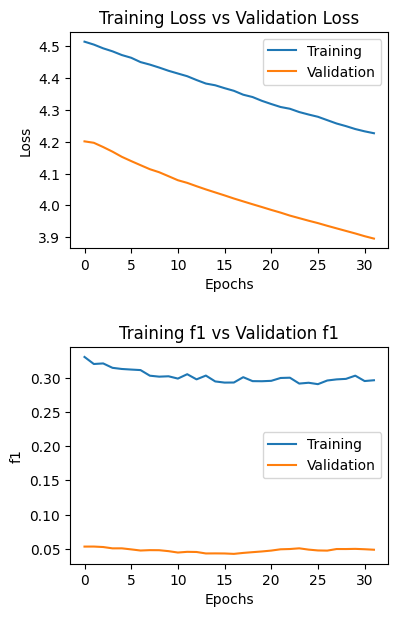

In [32]:
# Best params from previous trials
adam_learning_rate = 0.0000001
dropout = 0.075
loss_weight = 3
patience = 30
batch_size = 64
epochs = 500

# storing results
histories = []
results = []
model_list = []
f1_scores = []
run_times = []
print(datetime.now())
i = 0

for dim in [3]:

    start_time = datetime.now()

    # fit model
    model_, history, result = run_nn(num_feature=3, model_type="convolution", batch_size=batch_size, epochs=epochs,
            loss=wbce_custom(loss_weight), optimizer=Adam(learning_rate=adam_learning_rate), dropout=dropout, patience=patience,
            existing_model = None, metrics=['f1'], verbose=1, train_pairs = time_site_pairs_train_s2s3, test_pairs = time_site_pairs_test_s2s3,
            input_dim=51, expected_dim=dim)

    # f1 score
    f1_score = result[-1]

    if f1_score == np.nan:
        f1_score = 0

    # run times
    end_time = datetime.now()
    run_time = end_time - start_time

    # save model, history, result
    model_list.append(model_)
    histories.append(history)
    results.append(result)
    f1_scores.append(f1_score)
    run_times.append(run_time)

    i += 1
    clear_output(wait=True)
    print(f'Progress: {i}/5')
    print(datetime.now())

In [33]:
results

[[3.897895336151123,
  0.05996017903089523,
  0.036410924047231674,
  0.2772277295589447,
  0.04138940945267677,
  0.5627790689468384,
  0.7689687609672546]]

In [30]:
results

[[3.8010904788970947,
  0.04199167340993881,
  0.028298279270529747,
  0.2442244291305542,
  0.030770359560847282,
  0.5084912776947021,
  0.7379375696182251],
 [nan, nan, 0.0, 0.0, 0.02866603620350361, 0.5, 0.9713339805603027],
 [3.6997179985046387,
  0.040139228105545044,
  0.025423727929592133,
  0.1881188154220581,
  0.031841740012168884,
  0.4974380135536194,
  0.770009458065033],
 [3.849069356918335,
  0.05360669642686844,
  0.03269537538290024,
  0.40594059228897095,
  0.037867430597543716,
  0.5509620904922485,
  0.6386944055557251],
 [3.519697904586792,
  0.06609823554754257,
  0.04019719362258911,
  0.34983497858047485,
  0.03808945044875145,
  0.5540370345115662,
  0.7419110536575317]]

In [31]:
[result[1] for result in results]

[0.04199167340993881,
 nan,
 0.040139228105545044,
 0.05360669642686844,
 0.06609823554754257]